# Bayesian NMF

We will try to set up a MF workflow for the AMS data for Krakow, first we define our matrix factorization model, coming from the PyMC documentation. Notice that here `PMF` refers to Probabilistic Matrix Factorization instead of Positive Matrix Factorization as known in the air quality literature

In [1]:
import logging
import time

import scipy as sp
import theano
import pandas as pd
import numpy as np
import pymc3 as pm

from matplotlib import pyplot as plt

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


We load the original Krakow data in format itx, we resample at different resolutions

In [2]:
from src.python.aurora_py.itx_adapter import ItxAdapter

with open("../data/observations/KRK_input_10min.itx","r") as file:
    itx_adapter = ItxAdapter(file.read())

krakow_df = itx_adapter.to_pandas()
krakow_df.drop([12.0,37.0],axis=1,inplace=True)

krakow_df_30min = krakow_df.resample("30min").mean()
krakow_df_1h = krakow_df.resample("1H").mean()
krakow_df_1d = krakow_df.resample("1D").mean()

Non-negative matrix factorization model


In [3]:
# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = "ignore"

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF:
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 10 / self.data.var(axis=1).mean()
        self.alpha_v = 10 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model() as pmf:
            PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
            U = PositiveNormal(
                "U",
                mu=0,
                tau=self.alpha_u,
                shape=(n, dim)
            )
            V = PositiveNormal(
                "V",
                mu=0,
                tau=self.alpha_v,
                shape=(m, dim)
            )
            R = pm.Normal(
                "R", mu=(U @ V.T)[~nan_mask], tau=self.alpha, observed=self.data[~nan_mask]
            )


        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

    def _find_map(self):
        """Find mode of posterior using L-BFGS-B optimization."""
        tstart = time.time()
        with self.model:
            logging.info("finding PMF MAP using L-BFGS-B optimization...")
            self._map = pm.find_MAP(method="L-BFGS-B")

        elapsed = int(time.time() - tstart)
        logging.info("found PMF MAP in %d seconds" % elapsed)
        return self._map

    @property
    def map(self):
        try:
            return self._map
        except:
            return self._find_map()

    # Draw MCMC samples.
    def _draw_samples(self):
        with self.model:
            self._trace = pm.sample(chains=4)

    @property
    def trace(self):
        try:
            return self._trace
        except:
            return self._draw_samples()


    def _posterior_predicive(self):
        with self.model:
            self._ppc = pm.sample_posterior_predictive(self.trace, var_names=["R"])

    @property
    def ppc(self):
        return self._ppc

# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE




In [ ]:
    
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 8

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 11


pmf = PMF(krakow_df_1d.values, DIM, ALPHA, std=0.05)

# Find MAP for PMF
trace = pmf.trace;

INFO:root:building the PMF model
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpalahb7jj
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpi8pik5pq
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpk1tgi9q9
WARNING (theano.link.c.cmodule): Deleting (broken cache directory [EOF]): /Users/Daniel/.theano/compiledir_macOS-10.16-x86_64-i386-64bit-i386-3.9.12-64/tmpsvvx2fz2
INFO:root:done building the PMF model
/var/folders/dm/b79x42n96dl9s8jpb4t3_9lc0000gp/T/ipykernel_73558/612420354.py:88: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be 

In [62]:
ppc = pmf.ppc(1)

<AxesSubplot:xlabel='R'>

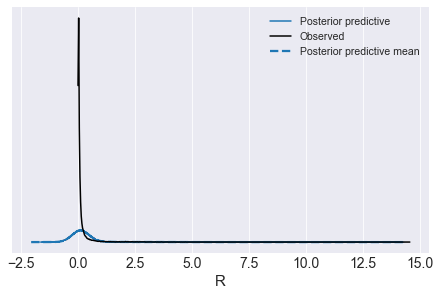

In [64]:
import arviz as az
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=pmf.model))

# Using Gaussian processes

In [13]:

normalized_time = (np.array(krakow_df.index.astype(int)) - np.min(np.array(krakov_df.index.astype(int))))
normalized_time = normalized_time /(np.max(normalized_time))
first_ts=krakow_df.iloc[:,0].values

display(normalized_time)
display(first_ts)
display(first_ts[np.isnan(first_ts)])

valid_times=~np.isnan(first_ts)

X_obs = np.expand_dims(normalized_time[valid_times],axis=1)
y_obs = first_ts[valid_times]
display(X_obs)
display(y_obs)

Xnew = np.expand_dims(normalized_time[~valid_times], axis=1)
X_ = np.expand_dims(normalized_time, axis=1)

array([0.00000000e+00, 9.12408759e-05, 1.82481752e-04, ...,
       9.99817518e-01, 9.99908759e-01, 1.00000000e+00])

array([ 0.042046  , -0.01037391,  0.01966863, ...,  0.07067725,
        0.00622268,  0.18474056])

array([nan, nan, nan, ..., nan, nan, nan])

array([[0.00000000e+00],
       [9.12408759e-05],
       [1.82481752e-04],
       ...,
       [9.99817518e-01],
       [9.99908759e-01],
       [1.00000000e+00]])

array([ 0.042046  , -0.01037391,  0.01966863, ...,  0.07067725,
        0.00622268,  0.18474056])

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from scipy.spatial.distance import pdist

%config InlineBackend.figure_format ='retina'

In [17]:
SEED = 2020
rng = np.random.default_rng(SEED)

In [19]:
X_[:,None]

array([[[0.00000000e+00]],

       [[9.12408759e-05]],

       [[1.82481752e-04]],

       ...,

       [[9.99817518e-01]],

       [[9.99908759e-01]],

       [[1.00000000e+00]]])

In [22]:
def get_ℓ_prior(points):
    """Calculates mean and sd for InverseGamma prior on lengthscale"""
    distances = pdist(points)
    distinct = distances != 0
    ℓ_l = distances[distinct].min() if sum(distinct) > 0 else 0.1
    ℓ_u = distances[distinct].max() if sum(distinct) > 0 else 1
    ℓ_σ = max(0.1, (ℓ_u - ℓ_l) / 6)
    ℓ_μ = ℓ_l + 3 * ℓ_σ
    return ℓ_μ, ℓ_σ


ℓ_μ, ℓ_σ = [stat for stat in get_ℓ_prior(X_)]

In [25]:
def plot_inducing_points(ax):
    yl = ax.get_ylim()
    yu = -np.subtract(*yl) * 0.025 + yl[0]
    ax.plot(Xu, np.full(Xu.shape, yu), "xk", label="Inducing Points")
    ax.legend(loc="upper left")


def get_quantiles(samples, quantiles=[2.5, 50, 97.5]):
    return [np.percentile(samples, p, axis=0) for p in quantiles]


def plot_mean(ax, mean_samples):
    """Plots the median and 95% CI from samples of the mean

    Note that, although each individual GP exhibits a normal distribution at each point
    (by definition), we are sampling from a mixture of GPs defined by the posteriors of
    our hyperparameters. As such, we use percentiles rather than mean +/- stdev to
    represent the spread of predictions from our models.
    """
    l, m, u = get_quantiles(mean_samples)
    ax.plot(Xnew, m, "C0", label="Median")
    ax.fill_between(Xnew_, l, u, facecolor="C0", alpha=0.5, label="95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X, y, "C1.", label="Observed Means")
    ax.set_title("Mean Behavior")
    ax.legend(loc="upper left")


def plot_var(ax, var_samples):
    """Plots the median and 95% CI from samples of the variance"""
    if var_samples.squeeze().ndim == 1:
        ax.plot(Xnew, var_samples, "C0", label="Median")
    else:
        l, m, u = get_quantiles(var_samples)
        ax.plot(Xnew, m, "C0", label="Median")
        ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="95% CI")
    ax.plot(Xnew, noise(signal(Xnew_)) ** 2, "--k", label="Noise Function")
    ax.plot(X, y_err ** 2, "C1.", label="Observed Variance")
    ax.set_title("Variance Behavior")
    ax.legend(loc="upper left")


def plot_total(ax, mean_samples, var_samples=None, bootstrap=True, n_boots=100):
    """Plots the overall mean and variance of the aggregate system

    We can represent the overall uncertainty via explicitly sampling the underlying normal
    distributrions (with `bootstrap=True`) or as the mean +/- the standard deviation from
    the Law of Total Variance. For systems with many observations, there will likely be
    little difference, but in cases with few observations and informative priors, plotting
    the percentiles will likely give a more accurate representation.
    """

    if (var_samples is None) or (var_samples.squeeze().ndim == 1):
        samples = mean_samples
        l, m, u = get_quantiles(samples)
        ax.plot(Xnew, m, "C0", label="Median")
    elif bootstrap:
        # Estimate the aggregate behavior using samples from each normal distribution in the posterior
        samples = (
            rng.normal(
                mean_samples.T[:, :, None],
                np.sqrt(var_samples).T[:, :, None],
                (*mean_samples.T.shape, n_boots),
            )
            .reshape(len(Xnew_), -1)
            .T
        )
        l, m, u = get_quantiles(samples)
        ax.plot(Xnew, m, "C0", label="Median")
    else:
        m = mean_samples.mean(axis=0)
        ax.plot(Xnew, m, "C0", label="Mean")
        sd = np.sqrt(mean_samples.var(axis=0) + var_samples.mean(axis=0))
        l, u = m - 2 * sd, m + 2 * sd

    ax.fill_between(Xnew.flatten(), l, u, facecolor="C0", alpha=0.5, label="Total 95% CI")

    ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X_obs, y_obs_, "C1.", label="Observations")
    ax.set_title("Aggregate Behavior")
    ax.legend(loc="upper left")

In [ ]:
%%script false
with pm.Model() as model_hm:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    cov = η ** 2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ℓ)

    gp_hm = pm.gp.Marginal(cov_func=cov)

    σ = pm.Exponential("σ", lam=1)

    ml_hm = gp_hm.marginal_likelihood("ml_hm", X=X_obs, y=y_obs, noise=σ)

    trace_hm = pm.sample(return_inferencedata=True, random_seed=SEED)

with model_hm:
    mu_pred_hm = gp_hm.conditional("mu_pred_hm", Xnew=Xnew)
    noisy_pred_hm = gp_hm.conditional("noisy_pred_hm", Xnew=Xnew, pred_noise=True)
    samples_hm = pm.sample_posterior_predictive(trace_hm, var_names=["mu_pred_hm", "noisy_pred_hm"])

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, η, ℓ]
INFO:pymc3:NUTS: [σ, η, ℓ]
